# Velocity estimation

In this tutorial the different velocity estimation method will be shown and tested. The user will learn how to change and configure these methods.

In [5]:
import numpy as np
from yupi import Trajectory, VelocityMethod, WindowType
import matplotlib.pyplot as plt

default_fig_size = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = (15, 5)

First, let's create three functions:

$$y_1(t) = t^2$$
$$y_2(t) = t^5 - 19t^3 + 25t^2 + 45t - 3$$
$$y_3(t) = \sin(t)$$

And their respective first derivative:

$$\frac{dy_1}{dt}(t) = 2t$$
$$\frac{dy_2}{dt}(t) = 5t^4 - 57t^2 + 50t + 45$$
$$\frac{dy_3}{dt}(t) = \cos(t)$$

In [6]:
t = np.linspace(-4, 4, 1000)

y1 = t ** 2
y2 = t ** 5 - 19 * t ** 3 + 25 * t ** 2 + 45 * t - 3
y3 = np.sin(t)

dy1 = 2 * t
dy2 = 5 * t ** 4 - 57 * t ** 2 + 50 * t + 45
dy3 = np.cos(t)

funcs = [y1, y2, y3]
derivs = [dy1, dy2, dy3]

Let's see how these functions and their derivatives look like

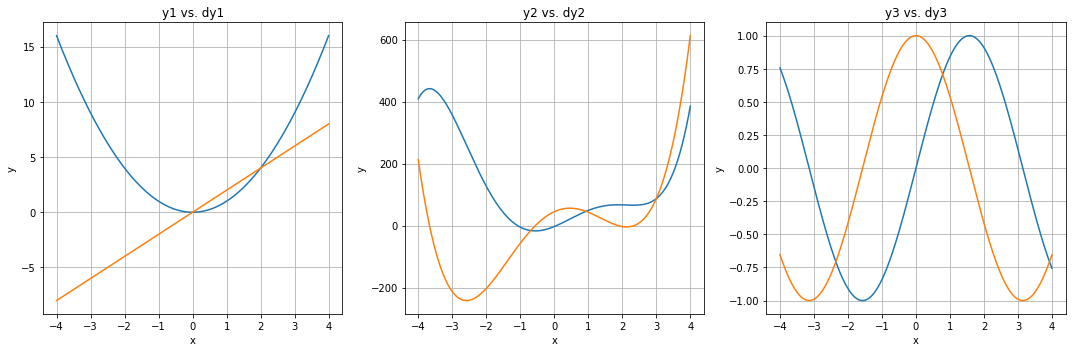

In [7]:
for i, func in enumerate(funcs):
    der = derivs[i]
    f_id = i + 1
    plt.subplot(130 + f_id)
    plt.title(f"y{f_id} vs. dy{f_id}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.plot(t, func)
    plt.plot(t, der)
plt.tight_layout()
plt.show()

If we think of $t$ as time and $y(t)$ a position at a given time, these functions can represent one dimensional trajectories.

In [8]:
def create_trajs(*args, time=None):
    time = t if time is None else time
    return [Trajectory(y, t=time) for y in args]

trajs = create_trajs(y1, y2, y3)

Knowing that the velocity is the position change rate with respect to the change of time ($\Delta x/\Delta t$), then the velocities of these trajectories should aproximate to the derivatives of the functions.

In **yupi** there are two principal velocity estimation methods: `LINEAR_DIFF` and `FORNBEGR_DIFF`, both based on the finte differences method. The `LINEAR_DIFF` method uses order one schemes to aproximate the derivative of a function. On the other hand, `FORNBERG_DIFF` method is based on the algorithm presented [here](https://www.ams.org/journals/mcom/1988-51-184/S0025-5718-1988-0935077-0/S0025-5718-1988-0935077-0.pdf). With this approach the derivative can be estimated with several order of accuracy (even if the data is not equally spaced). In both of this methods a window type can be specified (`FORWARD`, `BACKWARD`, `CENTRAL`). This parameter indicates whether the data for aproximating the derivative at an index $i$ is taken from the indices after, before or around $i$ respectively.

Trajectories in **yupi** use by default the `LINEAR_DIFF` method with a `CENTRAL` window type.

Let's compare estimated velocities from the previously created trajectories with the real values of the derivatives.

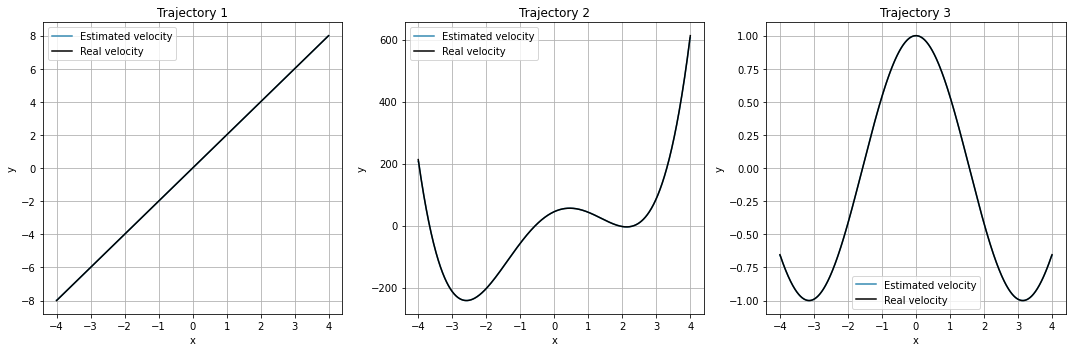

In [9]:
for i in range(3):
    traj = trajs[i]
    der = derivs[i]
    f_id = i + 1
    plt.subplot(130 + f_id)
    plt.title(f"Trajectory {f_id}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.plot(t, traj.v, color="#3489b1", label="Estimated velocity")
    plt.plot(t, der, "k", label="Real velocity")
    plt.legend()

plt.tight_layout()
plt.show()

They seems to be pretty accurate. But these are ideal cases, there is no noice in the data, the points are equally spaced and were sampled with a relatively high sample time (which is not the case in real life data usually).

## Testing with noicy data

Let's add some small gaussian noice to each of this values, create new trajectories with them, and check the velocity estimations.

In [10]:
np.random.seed(0)

noicy_y1 = y1 + np.random.normal(0, 0.002, len(y1))
noicy_y2 = y2 + np.random.normal(0, 0.20, len(y2))
noicy_y3 = y3 + np.random.normal(0, 0.002, len(y3))

noicy_funcs = [noicy_y1, noicy_y2, noicy_y3]

noicy_trajs = create_trajs(*noicy_funcs)

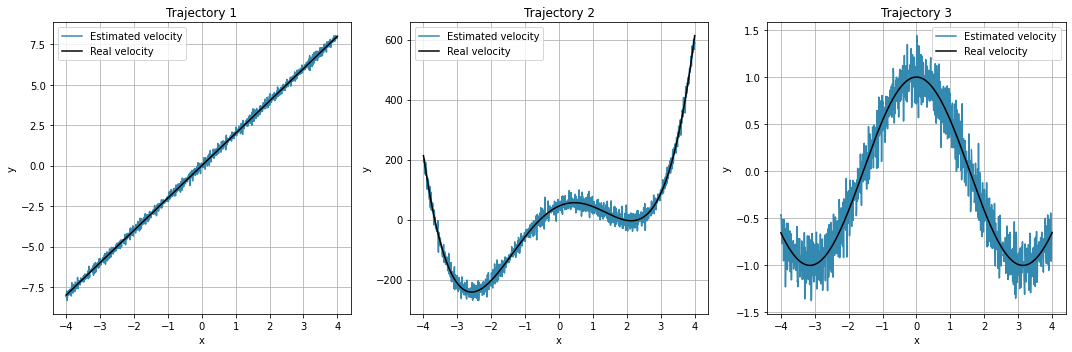

In [11]:
for i in range(3):
    traj = noicy_trajs[i]
    der = derivs[i]
    f_id = i + 1
    plt.subplot(130 + f_id)
    plt.title(f"Trajectory {f_id}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.plot(t, traj.v, color="#3489b1", label="Estimated velocity")
    plt.plot(t, der, "k", label="Real velocity")
    plt.legend()

plt.tight_layout()
plt.show()

One way for users to use another velocity aproximation method (or another parameter for the current method) is by the parameter `vel_est` of the trajectory constructor. This parameter recieve a dictionary with the wanted configuration. The possible keys are: `method`, `window_type` and `accuracy` wich defines the estimation method, the window type an the accuracy (this last is only valid if the method used is `FORNBERG_DIFF`). If one of the key is missing, the default value for that parameter will be assumed.

Let's create a new set of trajectories with the estmation method by default (`LINEAR_DIFF`) but this time using `FORWARD` window type, and compare the results.

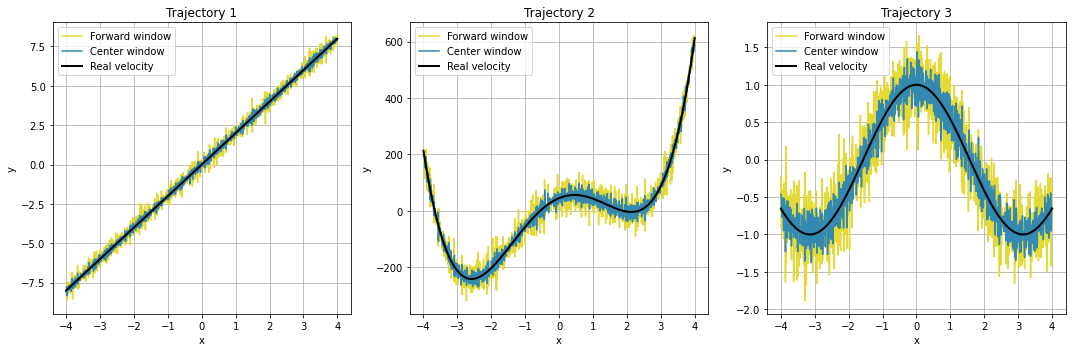

In [12]:
center_win_vels = [traj.v for traj in noicy_trajs]

forward_win_vels = [
    Trajectory(n, t=t, vel_est={"window_type": WindowType.FORWARD}).v for n in noicy_funcs
]

for i in range(3):
    center_win_vel = center_win_vels[i]
    forward_win_vel = forward_win_vels[i]
    der = derivs[i]
    f_id = i + 1
    plt.subplot(130 + f_id)
    plt.title(f"Trajectory {f_id}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.plot(t, forward_win_vel, color="#e5d935", label="Forward window")
    plt.plot(t, center_win_vel, color="#3489b1", label="Center window")
    plt.plot(t, der, "k", label="Real velocity", linewidth=2)
    plt.legend()

plt.tight_layout()
plt.show()

As we can see in the charts, using a `CENTRAL` window type gives us a better aproximation than using the `FORWARD` type. Let's test also the `FORNBERG_DIFF` method with a `CENTRAL` window type and a 4 level of accuracy (accuracy in `FORNBERG_DIFF` method must be always even if the window type is `CENTRAL`).

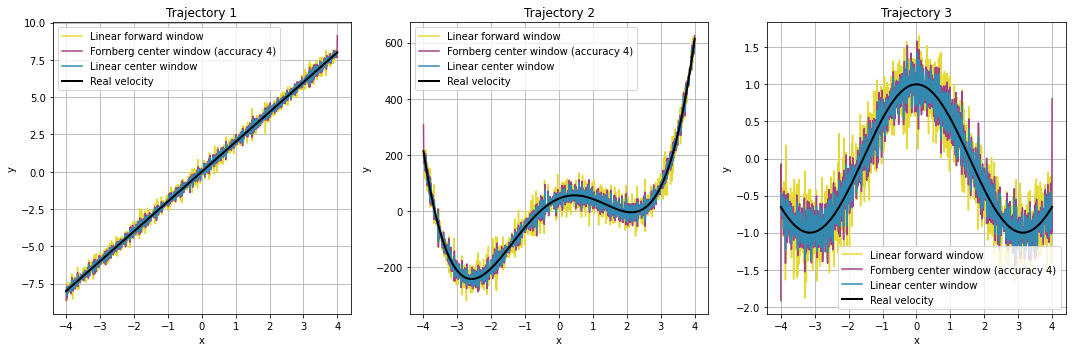

In [13]:
vel_est = {
    "method": VelocityMethod.FORNBERG_DIFF,
    "window_type": WindowType.CENTRAL,
    "accuracy": 4
}

est_vels = [Trajectory(n, t=t, vel_est=vel_est).v for n in noicy_funcs]

for i in range(3):
    center_win_vel = center_win_vels[i]
    forward_win_vel = forward_win_vels[i]
    est_vel = est_vels[i]
    der = derivs[i]
    f_id = i + 1
    plt.subplot(130 + f_id)
    plt.title(f"Trajectory {f_id}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.plot(t, forward_win_vel, color="#e5d935", label="Linear forward window")
    plt.plot(t, est_vel, color="#a14383", label="Fornberg center window (accuracy 4)")
    plt.plot(t, center_win_vel, color="#3489b1", label="Linear center window")
    plt.plot(t, der, "k", label="Real velocity", linewidth=2)
    plt.legend()

plt.tight_layout()
plt.show()

## Testing with non equally spaced data

Sometimes the trajectory data may be not equally spaced. In these cases traditional higer-order of accuracy derivation methods can't be use (there is no fixed $\Delta t$). For these cases, the `FORNBERG_DIFF` method can be used if the level of accuracy needs to be higher than 1. This level can be specified as mentioned before with the parameter `accuracy`.

Let's subsample in a non uniform way the current data and create a new set of trajectories.

In [14]:
indexes = np.sort(np.random.choice(range(len(t)), size=200, replace=False))
nes_t = t[indexes]  # Non equal spaced (nes)

nes_funcs = [y1[indexes], y2[indexes], y3[indexes]]
nes_trajs = create_trajs(*nes_funcs, time=nes_t)

There are two other forms for changing the velocity estimation configuration. If the trajectory is already created the instance functon `set_vel_method` can be use to achieve this as shown below.

If the default configuration wants to be modify, the static method `global_vel_method` can be used. This will affect all the trajectories created after.

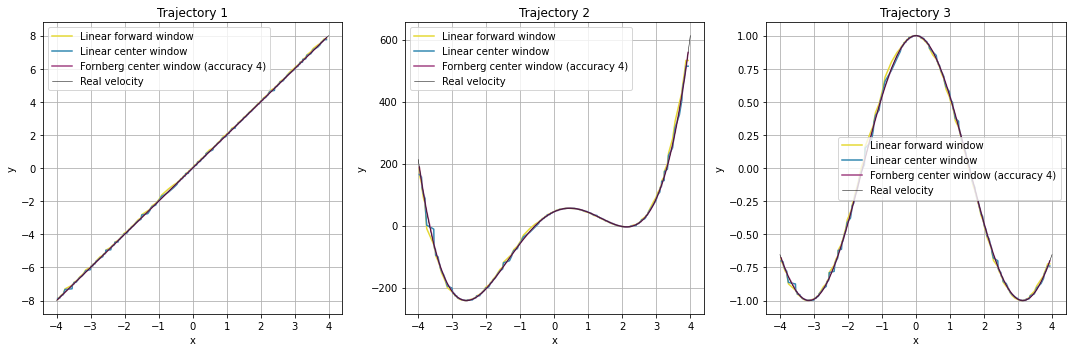

In [15]:
nes_center_win_vels = [traj.v for traj in nes_trajs]

nes_forward_win_vels = [traj.copy() for traj in nes_trajs]
for traj in nes_forward_win_vels:
    # Change the velocity estimation for a created trajectory
    traj.set_vel_method(
        method=VelocityMethod.LINEAR_DIFF,
        window_type=WindowType.FORWARD,
    )
nes_forward_win_vels = [traj.v for traj in nes_forward_win_vels]

# Change the global velocity estimation used as default
Trajectory.global_vel_method(
    method=VelocityMethod.FORNBERG_DIFF,
    window_type=WindowType.CENTRAL,
    accuracy=4
)
nes_est_vels = [Trajectory(n, t=nes_t).v for n in nes_funcs]

Trajectory.global_vel_method(
    method=VelocityMethod.LINEAR_DIFF,
    window_type=WindowType.CENTRAL,
)

for i in range(3):
    center_win_vel = nes_center_win_vels[i]
    forward_win_vel = nes_forward_win_vels[i]
    est_vel = nes_est_vels[i]
    der = derivs[i]
    f_id = i + 1
    plt.subplot(130 + f_id)
    plt.title(f"Trajectory {f_id}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.plot(nes_t, forward_win_vel, color="#e5d935", label="Linear forward window")
    plt.plot(nes_t, center_win_vel, color="#3489b1", label="Linear center window")
    plt.plot(nes_t, est_vel, color="#a14383", label="Fornberg center window (accuracy 4)")
    plt.plot(t, der, "k", label="Real velocity", linewidth=.5)
    plt.legend()

plt.tight_layout()
plt.show()

Although these are more accurate aproximations, the results show some visible irregularities in the estimations. As it is hard to compare the different configurations in these charts, let's check the absolute difference between the estimation and the real values.

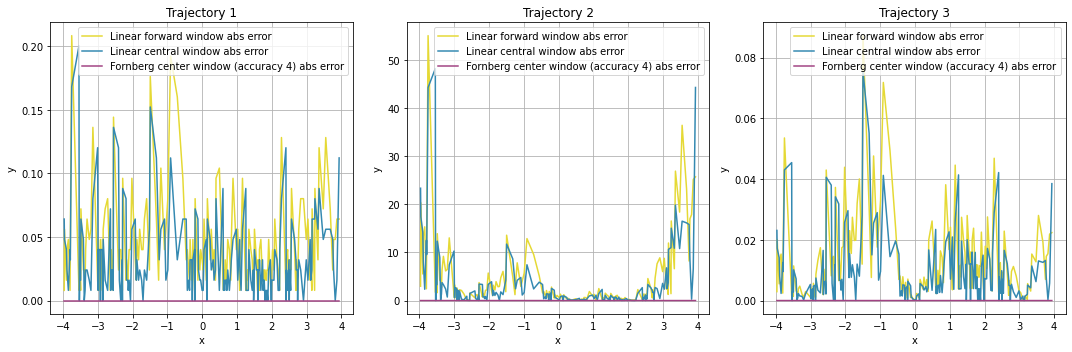

In [16]:
for i in range(3):
    center_win_vel = nes_center_win_vels[i]
    forward_win_vel = nes_forward_win_vels[i]
    est_vel = nes_est_vels[i]
    der = derivs[i]
    f_id = i + 1
    plt.subplot(130 + f_id)
    plt.title(f"Trajectory {f_id}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    err_1 = np.abs(forward_win_vel[:, 0] - der[indexes])
    err_2 = np.abs(center_win_vel[:, 0] - der[indexes])
    err_3 = np.abs(est_vel[:, 0] - der[indexes])
    plt.plot(nes_t, err_1, color="#e5d935", label="Linear forward window abs error")
    plt.plot(nes_t, err_2, color="#3489b1", label="Linear central window abs error")
    plt.plot(nes_t, err_3, color="#a14383", label="Fornberg center window (accuracy 4) abs error")
    plt.legend()

plt.tight_layout()
plt.show()

plt.rcParams['figure.figsize'] = default_fig_size

As the charts show, the `FORNBERG_DIFF` method is astonishing much accurate that the other methods in this case.

## Conclusion

These previous examples show there is no *better* method for estimating the velocitiy, it depends on the data and the user needs. This is the principal reason **yupi** offers two principal methods with adjustable parameters and easy configurations.